In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
    load_nearby_locations
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_ids = [x['id'] for x in session.execute(s)]

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [2]:
NUMBER_OF_NEARBY_LOCATIONS = 3

# select a location and the four closest to it
nearby_locations = load_nearby_locations(some_airlocation_ids[20], 50)[0:NUMBER_OF_NEARBY_LOCATIONS]

print("Predicting for: " + load_air_location_data(nearby_locations[0][0])['en_city_name'])
print("Using nearby locations: " + str([load_air_location_data(l[0])["short_name"] for l in nearby_locations[1:]]))

Predicting for: Chengdu Shi
Using nearby locations: ['China/成都/沙河铺', 'China/成都/三瓦窑']


In [3]:
loc_columns_format = ['loc_{}_id', 'loc_{}_measurement_datetime', 'loc_{}_aqi']

def initial_load_and_format_airlocation(airlocation_id, index):
    single_loc_df = load_measurement_data(airlocation_id)
    single_loc_df.columns = [c.format(index) for c in loc_columns_format]
    print("{} rows loaded for loc #{}".format(single_loc_df.count()[0], airlocation_id))
    return single_loc_df

dfs = [initial_load_and_format_airlocation(nearby_locations[0][0], 1)]

for index, location in enumerate(nearby_locations[1:]):
    loc_df = initial_load_and_format_airlocation(location[0], index + 2)
    dfs.append(loc_df)

36037 rows loaded for loc #964


37522 rows loaded for loc #802


37535 rows loaded for loc #633


In [4]:
from predict_aqi.transform_data import align_multi_location_time_series_data
import datetime

start = datetime.datetime.now()
df, continuous_time_series = align_multi_location_time_series_data(dfs, NUMBER_OF_NEARBY_LOCATIONS)
end = datetime.datetime.now()

In [5]:
print("Cleaning data took {} seconds".format((end - start).total_seconds()))

Cleaning data took 135.377615 seconds


In [6]:
print(continuous_time_series)

[(0, 589), (589, 590), (590, 658), (658, 1139), (1139, 1153), (1153, 1606), (1606, 2591), (2591, 2929), (2929, 8354), (8354, 9938), (9938, 11503), (11503, 19617), (19617, 23147), (23147, 23263), (23263, 23282), (23282, 25218), (25218, 26177), (26177, 26920), (26920, 27380), (27380, 28099), (28099, 29043), (29043, 30773), (30773, 30941), (30941, 34333), (34333, 34909), (34909, 34965), (34965, 34997), (34997, 35658), (35658, 35868)]


[0.0, 120000000.0, 0.0, 300.0]

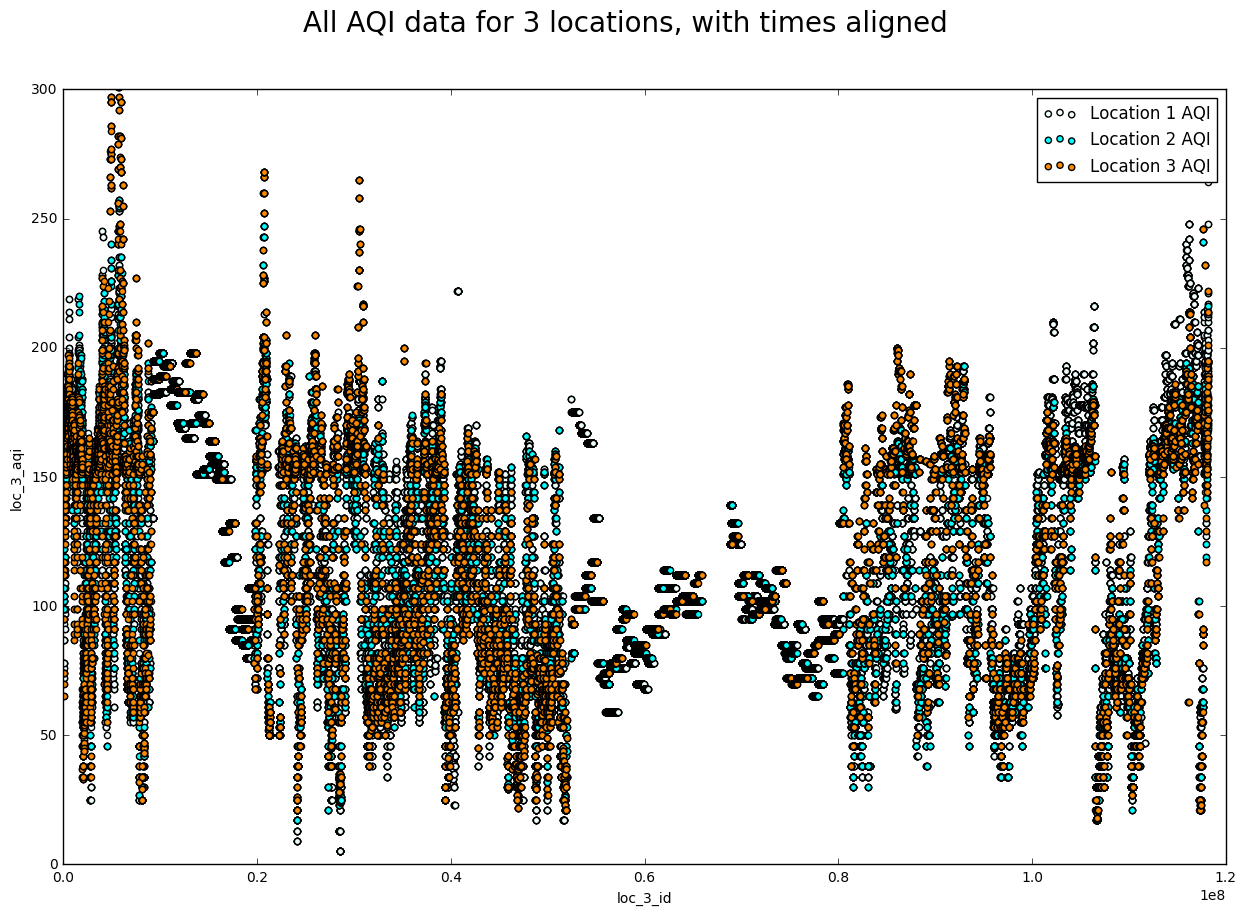

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
colours = sorted(list(cnames.keys()))
aqi_graph = df.plot.scatter(x='loc_1_id', y='loc_1_aqi', label="Location 1 AQI", color=colours[4])
for loc_num in range(2, NUMBER_OF_NEARBY_LOCATIONS + 1):
    df.plot.scatter(
        x='loc_{}_id'.format(loc_num), 
        y='loc_{}_aqi'.format(loc_num), 
        label="Location {} AQI".format(loc_num), 
        color=colours[loc_num*10], 
        ax=aqi_graph
    )

fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("All AQI data for {} locations, with times aligned".format(NUMBER_OF_NEARBY_LOCATIONS), fontsize=20)
aqi_graph.axis([0.0, 120000000.0, 0.0, 300.0])

In [8]:
# Select classifier to use
from predict_aqi.multi_city_model import generate_AQI_inputs_and_outputs
from predict_aqi import config
from predict_aqi.transform_data import clean_data, generate_time_inputs

INDICES_AHEAD_TO_PREDICT = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)

df, continuous_time_series, input_columns, output_columns = generate_AQI_inputs_and_outputs(
    df, continuous_time_series, INDICES_AHEAD_TO_PREDICT, NUMBER_OF_NEARBY_LOCATIONS
)

df = clean_data(df, output_columns, remove_dirty=False)

[0.0, 120000000.0, 0.0, 300.0]

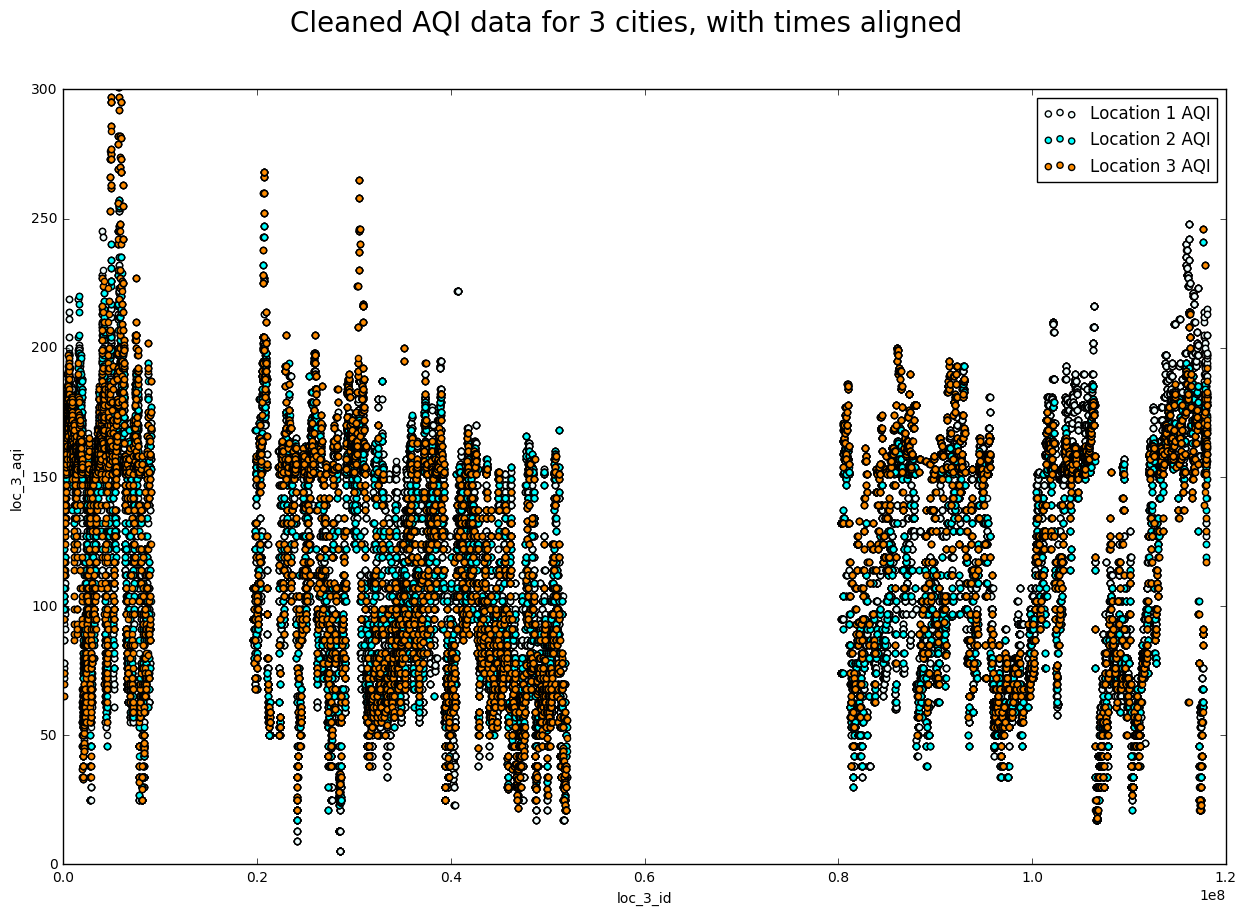

In [9]:
aqi_graph = df[df['is_dirty'] == False].plot.scatter(x='loc_1_id', y='loc_1_aqi', label="Location 1 AQI", color=colours[4])
for loc_num in range(2, NUMBER_OF_NEARBY_LOCATIONS + 1):
    df[df['is_dirty'] == False].plot.scatter(
        x='loc_{}_id'.format(loc_num), 
        y='loc_{}_aqi'.format(loc_num), 
        label="Location {} AQI".format(loc_num), 
        color=colours[loc_num*10], 
        ax=aqi_graph
    )

fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("Cleaned AQI data for {} cities, with times aligned".format(NUMBER_OF_NEARBY_LOCATIONS), fontsize=20)
aqi_graph.axis([0.0, 120000000.0, 0.0, 300.0])

In [10]:
# x = df[34658:][list(itertools.chain(input_columns, ['is_dirty']))]
# from sklearn.utils.validation import _assert_all_finite
# print(x.count()[0])
# for i in range(df.count()[0]):
#     _assert_all_finite(df.iloc[i])

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from predict_aqi.predictor_utils import train_regressor, predict_values

'''
Rows that are learned on meet the following criteria:
* All the locations have a valid AQI value within 10 minutes of each other (align_multi_location_time_series_data method)
* There are at least 3 different AQI values for the target location in the next 48 rows (clean_data method)
* The next 48 rows from any given valid row are in series, ~30 minutes apart
'''
def generate_predictions(
        df,
        continuous_time_series,
        input_columns,
        output_columns,
        split_function,
        regressors,
        print_progress):
    # x_train, y_train, x_test, y_test = split_function(
    #     df, input_columns, output_columns
    # )
    
    # Train regressors
    assert len(output_columns) == len(regressors)
    for series_start, series_end in continuous_time_series[:-1]:
        df_training_chunk = df[series_start:series_end]
        df_training_chunk = df_training_chunk[df['is_dirty'] == False]
        if df_training_chunk.count()[0] > 0 and split_function(series_start):
            for output_column, regressor in zip(output_columns, regressors):
                train_regressor(
                    regressor, 
                    df_training_chunk[input_columns], 
                    df_training_chunk[output_column], 
                    print_progress
                )
                
    # Make predictions
    for output_column, regressor in zip(output_columns, regressors):
        not_dirty_data = df[input_columns][df['is_dirty'] == False]
        predictions = predict_values(regressor, not_dirty_data, print_progress)
        predictions_df = pd.DataFrame(predictions, index=not_dirty_data.index)
        prediction_columns = [output_column.replace('_ahead_AQI', '_ahead_pred')]
        predictions_df.columns = prediction_columns
        df = df.join(predictions_df)
    
    return df


def generate_baseline_predictions(df, output_columns, source_column='loc_1_aqi'):
    for output_column in output_columns:
        prediction_column_name = output_column.replace('_ahead_AQI', '_ahead_baseline_pred') 
        df[prediction_column_name] = df[source_column]
    return df
    

row_count = df.count()[0]
split_row = int(round(row_count * 0.90))

# returns x_train, y_train, x_test, y_test
split_function = lambda df, input_columns, output_columns: \
    (df[input_columns][:split_row], 
     df[output_columns][:split_row], 
     df[input_columns][split_row:], 
     df[output_columns][split_row:])
split_function = lambda a: a < split_row

# make regressors for each index ahead to predict

regressors = [MLPRegressor() for i in INDICES_AHEAD_TO_PREDICT]

# generate predictions
this_iteration_df = generate_predictions(
    df,
    continuous_time_series,
    input_columns,
    output_columns,
    split_function,
    regressors,
    print_progress=False
)

this_iteration_df = generate_baseline_predictions(this_iteration_df, output_columns)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [33]:
# accumulate errors
errors_by_output_index = {'pred': {}, 'baseline_pred': {}}
clean_df = this_iteration_df[split_row:]
clean_df = clean_df[df['is_dirty'] == False]

errors = {'pred': {}, 'baseline_pred': {}}
for i in INDICES_AHEAD_TO_PREDICT:
    errors['pred'][i] = mean_absolute_error(
        clean_df['{}_ahead_AQI'.format(i)], 
        clean_df['{}_ahead_pred'.format(i)]
    )
    errors['baseline_pred'][i] = mean_absolute_error(
        clean_df['{}_ahead_AQI'.format(i)], 
        clean_df['{}_ahead_baseline_pred'.format(i)]
    )

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
